## Import modules

In [1]:
from common import colors

In [2]:
from __future__ import division

import os; os.chdir(os.path.join('..', '..', '..'))
print(os.getcwd())

/Users/eharkin/Documents/projects/5HTGIF


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gs
import seaborn as sns
import pandas as pd
from scipy import stats
from ezephys.pltools import hide_border
from ezephys.rectools import ABFLoader

from grr.Trace import detectSpikes
from grr.Tools import stripNan

In [4]:
plt.style.use(os.path.join('figs', 'scripts', 'writeup', 'publication_figure_style.dms'))
IMG_PATH = os.path.join('figs', 'ims', 'writeup', 'fI')

## Load data

First we'll just load the current step data.

In [5]:
DATA_PATH = os.path.join('data', 'raw', 'mPFC', 'current_steps')

fnames = pd.read_csv(os.path.join(DATA_PATH, 'index.csv'))
fnames

,Cell,R,C,hold,Steps
0,lea001,165,173,2,20302003.abf
1,lea002,135,223,-80,20302006.abf
2,lea003,210,230,-6,20302007.abf
3,lea004,127,218,10,20302008.abf
4,lea005,154,122,-40,20302009.abf
5,lea006,115,230,-20,20302011.abf
6,lea007,173,248,-3,20302012.abf


In [6]:
loader = ABFLoader()

Timesteps: [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]


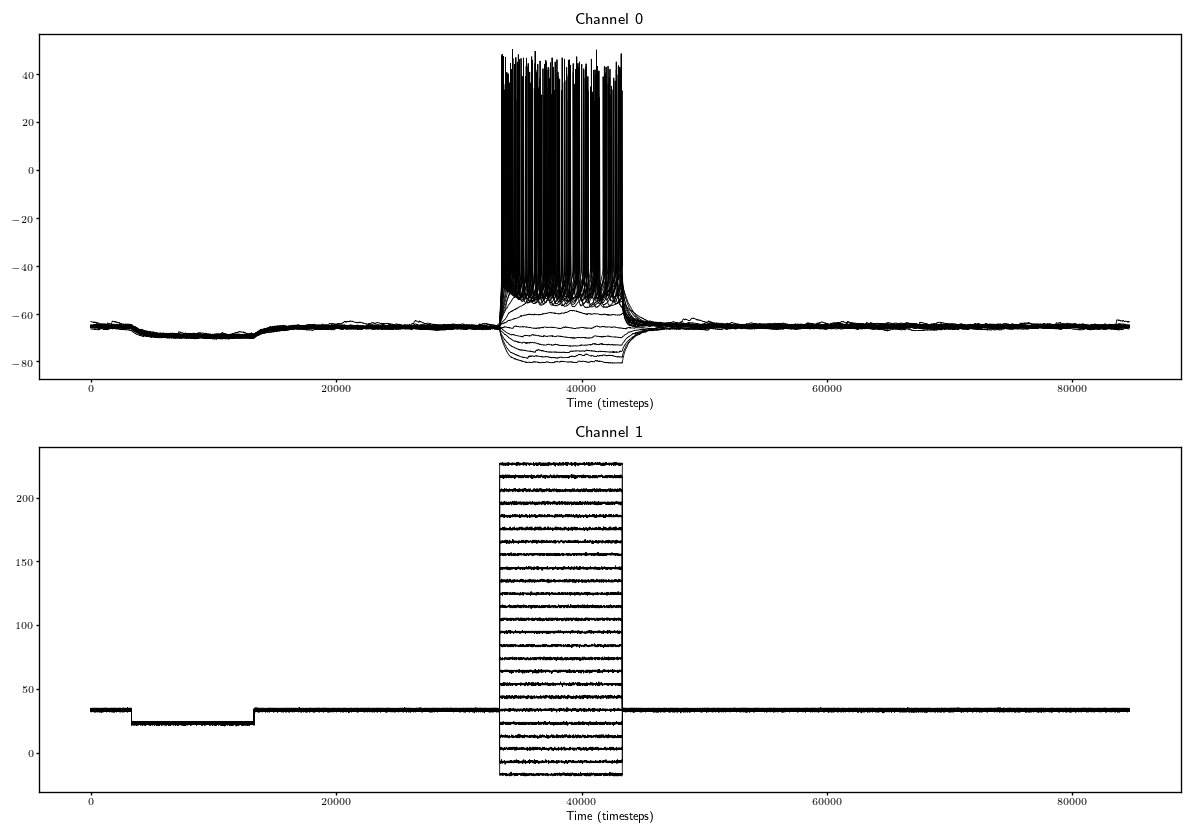

In [7]:
curr_steps = loader.load([os.path.join(DATA_PATH, fn) for fn in fnames['Steps']])
print('Timesteps: {}'.format([rec.dt for rec in curr_steps]))
curr_steps[0].plot()

Current step recordings have a similar structure, but differ in number of sweeps. Also possibly in spacing of current steps.

Automatically detect the start/end of the test pulse and current steps based on the first recording and then show whether this works for all cells.

In [8]:
change_threshold = 5. # pA threshold at which to detect a step.

tstpts = {}
mainpts = {}

try:
    tstpts['start'], mainpts['start'] = np.where(np.diff(curr_steps[0][1, :, 0]) < -change_threshold)[0]
    tstpts['stop'], mainpts['stop'] = np.where(np.diff(curr_steps[0][1, :, 0]) > change_threshold)[0]
except ValueError:
    print 'Too many or too few steps detected. Might need to adjust `change_threshold`.'
    raise

del change_threshold

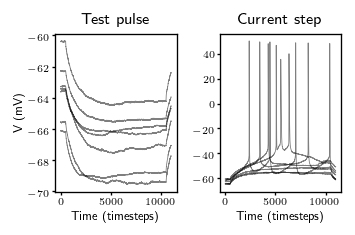

In [9]:
dt = 0.1 # ms. Assumed.

buffer_timesteps = 500

plt.figure()

tst_ax = plt.subplot(121)
tst_ax.set_title('Test pulse')

step_ax = plt.subplot(122)
step_ax.set_title('Current step')

for expt in curr_steps:
    tst_ax.plot(
        expt[0, (tstpts['start'] - buffer_timesteps):(tstpts['stop'] + buffer_timesteps), :].mean(axis = 1), 
        'k-', lw = 0.5, alpha = 0.5
    )
    step_ax.plot(
        expt[0, (mainpts['start'] - buffer_timesteps):(mainpts['stop'] + buffer_timesteps), 8], 
        'k-', lw = 0.5, alpha = 0.5
    )
    
tst_ax.set_xlabel('Time (timesteps)')
tst_ax.set_ylabel('V (mV)')

step_ax.set_xlabel('Time (timesteps)')
step_ax.set_ylabel('')

plt.tight_layout()

plt.show()

Quality control. Remove experiments where $I$ channel wasn't registered correctly. Cells being rejected are plotted, and number of retained cells is printed at the end.

In [10]:
qc_mask = []
for i, rec in enumerate(curr_steps):
    if (np.abs(rec[1, :, :] - np.mean(rec[1, :, :])) < 1.).all() :
        qc_mask.append(False)
        rec.plot()
    else:
        qc_mask.append(True)
        
curr_steps = [curr_steps[i] for i in range(len(curr_steps)) if qc_mask[i]]
print '{} of {} cells passed quality control.'.format(len(curr_steps), len(qc_mask))

del qc_mask

7 of 7 cells passed quality control.


## Generate f/I curves

f/I curves are usually rectified linear. However, in some cases non-monotonic f/I curves are observed, usually due to depolarization block.

In [11]:
# Detect spikes in all recordings.
spktimes = [detectSpikes(rec[0, :, :], 0., 3., 0, 0.1) for rec in curr_steps]

In [12]:
spktimes

[[array([], dtype=float64),
  array([], dtype=float64),
  array([], dtype=float64),
  array([], dtype=float64),
  array([], dtype=float64),
  array([], dtype=float64),
  array([], dtype=float64),
  array([3799.3, 4121.6]),
  array([3520.1, 3726.9, 3983.3, 4322.6]),
  array([3454.1, 3621.6, 3815.9, 4036.3, 4287.1]),
  array([3436.6, 3571. , 3717.8, 3890.1, 4079.4, 4282.7]),
  array([3415.9, 3527.4, 3653.9, 3803.1, 3960.6, 4141.2, 4320.2]),
  array([3401.8, 3509.1, 3629.2, 3759.6, 3892.4, 4039.9, 4191.2]),
  array([3391.2, 3484.5, 3593.6, 3714.7, 3841.6, 3981.3, 4109.8, 4247. ]),
  array([3380.4, 3464.4, 3563.8, 3673.9, 3784.4, 3899.6, 4018.1, 4135.2,
         4262.1]),
  array([3377.1, 3454.1, 3550.5, 3649. , 3754.9, 3860.5, 3971.3, 4089. ,
         4215.3]),
  array([3368. , 3440.5, 3524. , 3614. , 3708.5, 3807.8, 3909.4, 4015.7,
         4121.9, 4236.9]),
  array([3365. , 3427.8, 3506.6, 3597.6, 3685.3, 3777. , 3875.1, 3970.5,
         4073. , 4175.2, 4285.7]),
  array([3362.5, 3420.4

In [13]:
# Extract f/I data.

# Dict to hold output.
fi_data = {'f': [], 'I': [], 'CV': [], 'rheobase': [], 'coeffs': [], 'is_monotonic': []}

# Throwaway function to detect whether an f/I curve increases monotonically.
is_monotonic = lambda x_: np.all(np.nan_to_num(np.diff(x_) / x_[:-1]) > -0.25)

for rec, times in zip(curr_steps, spktimes):
    
    spks_in_window = [x[np.logical_and(x >= mainpts['start'] * dt, x < mainpts['stop'] * dt)] * dt for x in times]
    ISIs_tmp = [np.diff(x) for x in spks_in_window]
    cv_tmp = [x.std() / x.mean() if len(x) > 0 else 0 for x in ISIs_tmp]
    
    f_tmp = np.array(
            [len(x) for x in spks_in_window]
        ) / (1e-3 * dt * (mainpts['stop'] - mainpts['start'])) # Convert to a rate in Hz.
    I_tmp = rec[1, (mainpts['stop'] - 1000):(mainpts['stop'] - 10), :].mean(axis = 0) # Scrape input current.
    
    try:
        rheobase_ind = np.where(f_tmp > 1e-4)[0][0]
    except IndexError:
        rec.plot()
        print f_tmp
        print times
        raise
    
    if is_monotonic(f_tmp):
        coeffs_tmp = np.polyfit(I_tmp[rheobase_ind:], f_tmp[rheobase_ind:], 1)
    else:
        coeffs_tmp = [np.nan for i in range(2)]
        
    fi_data['f'].append(f_tmp)
    fi_data['I'].append(I_tmp)
    fi_data['CV'].append(cv_tmp)
    fi_data['rheobase'].append(I_tmp[rheobase_ind])
    fi_data['coeffs'].append(coeffs_tmp)
    fi_data['is_monotonic'].append(is_monotonic(f_tmp))
    
fi_data['coeffs'] = np.array(fi_data['coeffs'])

/miniconda3/envs/neopozz/lib/python2.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in true_divide
  import sys
/miniconda3/envs/neopozz/lib/python2.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys


In [15]:
fi_df = pd.DataFrame({'rheobase': fi_data['rheobase'], 'gain': fi_data['coeffs'][:, 0], 'is_monotonic': fi_data['is_monotonic']})
fi_df.to_csv(os.path.join('data', 'processed', 'mPFC', 'current_steps_gain.csv'), index=False)

/miniconda3/envs/neopozz/lib/python2.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in true_divide
  import sys
/miniconda3/envs/neopozz/lib/python2.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys


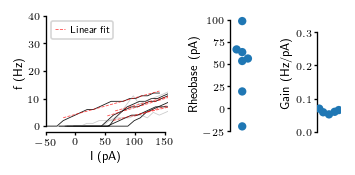

In [16]:
# Plot f/I curves.

plt.figure(figsize=(3, 1.5))

spec = gs.GridSpec(1, 3, width_ratios=[1, 0.2, 0.2])

curves = plt.subplot(spec[:, 0])

legend_flag = False
for x, y, coeffs in zip(fi_data['I'], fi_data['f'], fi_data['coeffs']):
    
    if is_monotonic(y):
        curves.plot(x, y, 'k-', alpha = 0.9)
        
        if not legend_flag:
            curves.plot(
                x[y>1e-3],
                np.polyval(coeffs, x[y>1e-3]),
                'r--',
                alpha = 0.7,
                label = 'Linear fit'
            )
            legend_flag = True
        else:
            curves.plot(x[y>1e-3], np.polyval(coeffs, x[y>1e-3]), 
                             'r--', alpha = 0.7)
    else:
        curves.plot(x, y, '-', color = 'gray', alpha = 0.4)

curves.set_xlim(-50, 155)
curves.set_ylim(-2, 40)

curves.legend(loc='upper left')
curves.set_xlabel('I (pA)')
curves.set_ylabel('f (Hz)')
hide_border('tr', ax=curves, trim=True)

rheobase_dist = plt.subplot(spec[:, 1])
sns.swarmplot(y=fi_data['rheobase'], ax=rheobase_dist)
hide_border('trb', trim=True, ax=rheobase_dist)
rheobase_dist.set_ylabel('Rheobase (pA)')

gain_dist = plt.subplot(spec[:, 2])
gain_dist.set_ylim(0, 0.35)
sns.swarmplot(y=stripNan(fi_data['coeffs'][:, 0]), ax=gain_dist)
gain_dist.set_ylabel('Gain (Hz/pA)')
hide_border('trb', trim=True, ax=gain_dist)

plt.tight_layout()

if IMG_PATH is not None:
    plt.savefig(os.path.join(IMG_PATH, 'mPFC_fi_curves.png'))
    plt.savefig(os.path.join(IMG_PATH, 'mPFC_fi_curves.svg'))

plt.show()

/miniconda3/envs/neopozz/lib/python2.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in true_divide
  import sys
/miniconda3/envs/neopozz/lib/python2.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys


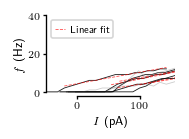

In [17]:
plt.figure(figsize=(1.5, 1))

curves = plt.subplot(111)

legend_flag = False
for x, y, coeffs in zip(fi_data['I'], fi_data['f'], fi_data['coeffs']):
    
    if is_monotonic(y):
        curves.plot(x, y, 'k-', alpha = 0.9)
        
        if not legend_flag:
            curves.plot(
                x[y>1e-3],
                np.polyval(coeffs, x[y>1e-3]),
                'r--',
                alpha = 0.7,
                label = 'Linear fit'
            )
            legend_flag = True
        else:
            curves.plot(x[y>1e-3], np.polyval(coeffs, x[y>1e-3]), 
                             'r--', alpha = 0.7)
    else:
        curves.plot(x, y, '-', color = 'gray', alpha = 0.4)

curves.set_xlim(-50, 155)
curves.set_ylim(-2, 40)

curves.legend(loc='upper left')
curves.set_xlabel('$I$ (pA)')
curves.set_ylabel('$f$ (Hz)')
hide_border('tr', ax=curves, trim=True)

plt.subplots_adjust(top=0.97, right=0.97, bottom=0.3, left=0.25)

if IMG_PATH is not None:
    plt.savefig(os.path.join(IMG_PATH, 'mPFC_fi_curve_only.png'))
    plt.savefig(os.path.join(IMG_PATH, 'mPFC_fi_curve_only.svg'))

In [18]:
print(
    'Rheobase: {:.3f} +/- {:.3f} pA'.format(
        np.nanmean(fi_data['rheobase']), stats.sem(fi_data['rheobase'], nan_policy='omit')
    )
)
print(
    'Gain: {:.3f} +/- {:.3f} Hz/pA'.format(
        np.nanmean(fi_data['coeffs'][:, 0]), stats.sem(fi_data['coeffs'][:, 0], nan_policy='omit')
    )
)

Rheobase: 48.393 +/- 14.467 pA
Gain: 0.061 +/- 0.003 Hz/pA


Half of the cells have linear monotonic curves. Current steps of cells from the non-monotonic group are below.

/miniconda3/envs/neopozz/lib/python2.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in true_divide
  import sys
/miniconda3/envs/neopozz/lib/python2.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys


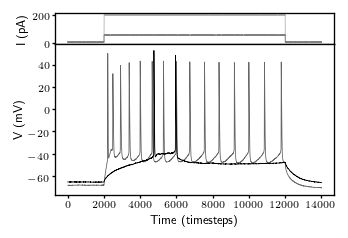

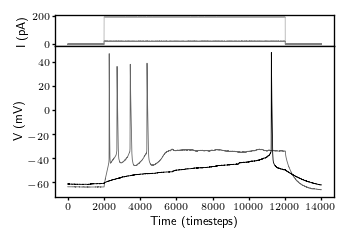

In [19]:
for y, rec in zip(fi_data['f'], curr_steps):
    if not is_monotonic(y):
        first_sweep_with_spikes = np.min(np.where(y > 0)[0])
        
        plt.figure()
        spec_tmp = gs.GridSpec(2, 1, height_ratios = [0.2, 1], hspace = 0)
        
        plt.subplot(spec_tmp[0, :])
        plt.plot(
            rec[1, (mainpts['start'] - 2000):(mainpts['stop'] + 2000), first_sweep_with_spikes],
            '-', color = 'gray', lw = 0.5
        )
        plt.plot(
            rec[1, (mainpts['start'] - 2000):(mainpts['stop'] + 2000), -1],
            '-', color = 'gray', lw = 0.5, alpha = 0.6
        )
        
        plt.ylabel('I (pA)')
        
        plt.subplot(spec_tmp[1, :])
        plt.plot(
            rec[0, (mainpts['start'] - 2000):(mainpts['stop'] + 2000), first_sweep_with_spikes],
            'k-', lw = 0.5
        )
        plt.plot(
            rec[0, (mainpts['start'] - 2000):(mainpts['stop'] + 2000), -1],
            'k-', lw = 0.5, alpha = 0.6
        )
        
        plt.ylabel('V (mV)')
        plt.xlabel('Time (timesteps)')
        
        plt.show()